In [1]:
import multiprocessing
import os
from re import A
from typing import ItemsView

from py import log
os.environ['PYTHONDONTWRITEBYTECODE'] = '1'
from xtquant import xttrader
from xtquant.xttrader import XtQuantTrader, XtQuantTraderCallback
from xtquant.xttype import StockAccount
from xtquant import xtconstant
import pandas_market_calendars as mcal
import pandas as pd
import akshare as ak

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
def plot(df, column):
    
    # 设置中文字体
    mpl.rcParams['font.sans-serif'] = ['SimHei']  # 指定中文字体为 SimHei
    mpl.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

    # 假设这是你的DataFrame，其中包含收益

    # 绘制收益曲线
    # 将日期列转换为日期类型
    # df['date'] = pd.to_datetime(df['date'])

    # # 设置日期列为索引
    # df.set_index('date', inplace=True)
    df.index = pd.to_datetime(df.index)
    # 绘制收益曲线
    plt.figure(figsize=(10, 6))  # 设置图表大小
    plt.plot(df.index, df[column], label='Return')
    plt.title('收益曲线')
    plt.xlabel('日期')
    plt.ylabel('收益率')
    plt.legend()  # 显示图例
    plt.grid(True)  # 显示网格线

    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    # plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=10))

    plt.show()

d:\anaconda3\envs\python3.8\lib\site-packages\exchange_calendars\exchange_calendar.py:2345: FutureWarning: 'T' is deprecated and will be removed in a future version. Please use 'min' instead of 'T'.
  align: pd.Timedelta | str = pd.Timedelta(1, "T"),


In [2]:
from xtquant import xtdatacenter as xtdc
xtdc.set_token("26e6009f4de3bfb2ae4b89763f255300e96d6912")

print('xtdc.init')
xtdc.init() # 初始化行情模块，加载合约数据，会需要大约十几秒的时间
print('done')

from xtquant import xtdata 

xtdc.init
done


In [3]:
import sys
sys.path.append(r"D:\workspace\TradeX\ezMoney")
from http_request import build_http_request
from data_class import category_rank_class
def get_ranked_category_infos(date_key, except_is_ppp = True, except_is_track = False, gap = 10):
    # build_http_request.check_user_alive()
    categoryRankList = category_rank_class.build_category_rank_sort_list(date_key)
    block_rank_list = []
    for item in categoryRankList:
        if item == None:
            continue
        if item.stockType == 'industry':
            isPpp = item.isPpp
            num = item.num
            numChange = item.numChange
            isTrack = item.isTrack
            stockCode = item.categoryCode
            r  = {
                'isPpp': isPpp,
                'num': num,
                'numChange': numChange,
                'isTrack': isTrack,
                'blockCode': stockCode
            }
            block_rank_list.append(r)
        if item.blockRankList == None:
            continue
        block_rank_list.extend(item.blockRankList)

    if except_is_ppp:
        block_rank_list = [item for item in block_rank_list if not item['isPpp']]
    if except_is_track:
        block_rank_list = [item for item in block_rank_list if not item['isTrack']]

    sorted_block_rank_list = sorted(block_rank_list, key=lambda x: (-x['num'], -x['numChange']))
    rank_dict = {}
    prev_num = None
    current_rank = 1

    for idx, item in enumerate(sorted_block_rank_list):
        code = item['blockCode']
        num = item['num']

        if idx == 0:
            # 第一个元素直接赋初始排名
            rank_dict[code] = current_rank
            prev_num = num
            continue

        delta = 0
        diff = prev_num - num

        # 判断差值规则
        if abs(diff) <= 0.0001:
            delta = 0
        else:
            if gap == 0:
                delta = 1
            else:
                if diff > gap:
                    delta = int(diff // gap) + 1
                else:
                    delta = 1
        current_rank += delta
        rank_dict[code] = current_rank
        prev_num = num
    return rank_dict

In [ ]:


hd_pct = 0.001

strategy_name = '连断追涨'
days = 5
#胜率最高
params = [
              {
        "filtered": True,
        "fx_filtered": False,
        "topn": 1,
        "top_fx": 2,
        "top_cx": 2,
        "only_fx": False,
        "enbale_industry": False,
        "empty_priority": False
      },
      
        ]

filter_count = 0
filter_amount = 8000000
gap = 0
rank_filter = True

In [5]:
def get_first_tick_trade_amount(stock_code, datekey):
    import datetime
    import pandas as pd

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 20, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 26, 0)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.tail(1)

    amount = min_time_row['amount']

    if len(amount) == 1:
        real_amount = amount.item()
    else:
        print(f"error: {stock_code}-{datekey}-{len(amount)}")
        real_amount = 0

    return real_amount

def get_real_open_price(stock_code, datekey):
    import datetime

    today = datetime.datetime.strptime(datekey, '%Y-%m-%d').date()

    time_0930 = datetime.time(9, 29, 0)

    dt_0930 = datetime.datetime.combine(today, time_0930)

    timestamp_0930 = dt_0930.timestamp()

    time_09305 = datetime.time(9, 30, 5)

    dt_09305 = datetime.datetime.combine(today, time_09305)

    timestamp_09305 = dt_09305.timestamp()

    tims = int(timestamp_0930*1000)

    tims5 = int(timestamp_09305*1000)
    import numpy as np
    n_data_key = datekey.replace('-', '')
    xtdata.download_history_data(stock_code, 'tick', n_data_key, n_data_key)
    all_tick_data = xtdata.get_market_data(stock_list=[stock_code], period='tick', start_time=n_data_key, end_time=n_data_key)

    # 假设 all_tick_data['000759.SZ'] 是 numpy.void 数组
    if isinstance(all_tick_data[stock_code], np.ndarray) and all_tick_data[stock_code].dtype.type is np.void:
        df = pd.DataFrame(all_tick_data[stock_code].tolist(), columns=all_tick_data[stock_code].dtype.names)
    else:
        raise

    filtered_df = df[(df['time'] >= tims) & (df['time'] <= tims5)]

    # 按 time 列升序排序
    sorted_df = filtered_df.sort_values(by='time')

    # 取 time 最小的行
    min_time_row = sorted_df.head(1)

    last_price = min_time_row['lastPrice']

    # 检查 Series 是否只有一个元素
    if len(last_price) == 1:
        last_price_real = last_price.item()
    else:
        raise Exception(f"{stock_code}-{datekey}")

    return last_price_real

In [6]:
all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock

def group_filter_fx(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
                
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
            
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()
            
            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row

            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            else:
                category_filtered = group[(group['max_block_category_rank'] <= top_fx) & ((group['max_block_code_rank'] <= top_cx) | (group['max_industry_code_rank'] <= top_cx))]
                if len(category_filtered) == 0:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row

                result = category_filtered[category_filtered['max_block_code_rank'] == category_filtered['max_block_code_rank'].min()]
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row



def group_filter(group, filtered = True, fx_filtered = True, topn = 3, top_fx = 2, top_cx = 2, only_fx = False, enbale_industry= False, filter_amount = filter_amount, all_stocks = all_stocks):
    if filter_amount > 0:
        masks = []
        first_tick_amounts = []  # 存储每行的 first_tick_amount
        
        # 遍历每一行并计算值
        for _, row in group.iterrows():
            stock_code = all_stocks[row['stock_code'].split('.')[0]]
            date_key = row['date_key']
            if row['stock_code'].split('.')[0] not in all_stocks:
                masks.append(False)
                first_tick_amounts.append(0)
                continue
            # 计算 first_tick_amount
            first_tick_amount = get_first_tick_trade_amount(stock_code, date_key)
            first_tick_amounts.append(first_tick_amount)  # 记录值
            if first_tick_amount > filter_amount:
                masks.append(True)
            else:
                print(f"过滤股票 {stock_code} 日期 {date_key} 过滤原因： first_tick_amount {first_tick_amount}")
                masks.append(False)
                global filter_count
                filter_count = filter_count + 1
            # 生成过滤掩码
        
        # 将 first_tick_amount 添加到原始分组中
        group = group.copy()  # 避免 SettingWithCopyWarning
        group['first_tick_amount'] = first_tick_amounts
        
        # 应用过滤
        group = group[masks]
    if not filtered:
        valid_rows = group[(group['open_price'] > 0) & (group['next_day_open_price'] > 0) & (group['stock_rank'] <= topn) & (group['next_day_close_price'] > 0)]
        if len(valid_rows) > 0:
            valid_rows['return'] = valid_rows['next_day_open_price'] / valid_rows['open_price'] - 1
            valid_rows['real_return'] = valid_rows['return'] - hd_pct
            valid_rows['close_return'] = valid_rows['next_day_close_price'] / valid_rows['open_price'] - 1
            valid_rows['close_real_return'] = valid_rows['close_return'] - hd_pct
            avg_value = valid_rows['return'].mean()
            close_avg_value = valid_rows['close_return'].mean()
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                # 将平均值赋给 rank 为 1 的行的指定列
                rank_one_row['return'] = avg_value
                rank_one_row['real_return'] = avg_value - hd_pct
                rank_one_row['close_return'] = close_avg_value
                rank_one_row['close_real_return'] = close_avg_value - hd_pct
                return rank_one_row
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if len(rank_one_row) > 0:
                rank_one_row['return'] = -10
                rank_one_row['real_return'] = -10
                rank_one_row['close_return'] = -10
                rank_one_row['close_real_return'] = -10
                return rank_one_row
    else:
        if fx_filtered:
            min_category_rank = group['max_block_category_rank'].min()

            industry_rank_one_row = group[group['max_industry_code_rank'] == 1].copy()
            if not industry_rank_one_row.empty and len(industry_rank_one_row) == 1 and enbale_industry:
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            elif not industry_rank_one_row.empty and len(industry_rank_one_row) > 1 and enbale_industry:
                industry_rank_one_row = industry_rank_one_row[industry_rank_one_row['stock_rank'] == industry_rank_one_row['stock_rank'].min()]
                industry_rank_one_row['return'] = industry_rank_one_row['next_day_open_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['real_return'] = industry_rank_one_row['return'] - hd_pct
                industry_rank_one_row['close_return'] = industry_rank_one_row['next_day_close_price'] / industry_rank_one_row['open_price'] - 1
                industry_rank_one_row['close_real_return'] = industry_rank_one_row['close_return'] - hd_pct
                return industry_rank_one_row
            
            if min_category_rank > top_fx:
                if only_fx:
                    return group[group['max_block_category_rank'] < min_category_rank]
                rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                if len(rank_one_row) > 0:
                    rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                    rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                    rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                    return rank_one_row
            elif min_category_rank < 0:
                category_filtered = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                if not category_filtered.empty and len(category_filtered) > 0:
                    category_filtered = category_filtered[category_filtered['stock_rank'] == category_filtered['stock_rank'].min()]
                    category_filtered['return'] = category_filtered['next_day_open_price'] / category_filtered['open_price'] - 1
                    category_filtered['real_return'] = category_filtered['return'] - hd_pct
                    category_filtered['close_return'] = category_filtered['next_day_close_price'] / category_filtered['open_price'] - 1
                    category_filtered['close_real_return'] = category_filtered['close_return'] - hd_pct
                    return category_filtered
                else:
                    rank_one_row = group[group['max_block_category_rank'] == min_category_rank]
                    if len(rank_one_row) > 0:
                        rank_one_row = rank_one_row[rank_one_row['stock_rank'] == rank_one_row['stock_rank'].min()].copy()
                        if not rank_one_row.empty and len(rank_one_row) > 0:
                            rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                            rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                            rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                            return rank_one_row
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                    else:
                        raise Exception("No data.")
            else:
                result = group[(group['max_block_category_rank'] > 0) & (group['max_block_category_rank'] <= top_fx) & (((group['max_block_code_rank'] <= top_cx) & (group['max_block_code_rank'] > 0)) | ((group['max_industry_code_rank'] <= top_cx) & (group['max_industry_code_rank'] > 0)))]
                
                if result.empty or len(result) < 1:
                    if only_fx:
                        return group[group['max_block_category_rank'] < min_category_rank]
                    rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
                    if not rank_one_row.empty and len(rank_one_row) > 0:
                        rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                        rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                        rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
                        return rank_one_row
                if len(result) > 1:
                    result = result[result['stock_rank'] == result['stock_rank'].min()]
                result['return'] = result['next_day_open_price'] / result['open_price'] - 1
                result['real_return'] = result['return'] - hd_pct
                result['close_return'] = result['next_day_close_price'] / result['open_price'] - 1
                result['close_real_return'] = result['close_return'] - hd_pct
                return result
        else:
            rank_one_row = group[group['stock_rank'] == group['stock_rank'].min()].copy()
            if not rank_one_row.empty and len(rank_one_row) > 0:
                rank_one_row['return'] = rank_one_row['next_day_open_price'] / rank_one_row['open_price'] - 1
                rank_one_row['real_return'] = rank_one_row['return'] - hd_pct
                rank_one_row['close_return'] = rank_one_row['next_day_close_price'] / rank_one_row['open_price'] - 1
                rank_one_row['close_real_return'] = rank_one_row['close_return'] - hd_pct
            return rank_one_row


***** xtdata连接成功 *****
服务信息: {'tag': 'xtquant', 'version': '1.0'}
服务地址: 127.0.0.1:58609
数据路径: d:\workspace\TradeX\notebook\data\datadir
设置xtdata.enable_hello = False可隐藏此消息



In [7]:
param0 = params[0]
empty_priority = param0['empty_priority']
del param0['empty_priority']
if empty_priority:
    filter_func = group_filter_fx
else:
    filter_func = group_filter

In [8]:
import sqlite3
# months = ['202502']
months = ['202409', '202410', '202411', '202412', '202501', '202502', '202503']
# months = ['202409', '202410']
combined_df = pd.DataFrame()
for month in months:
    conn = sqlite3.connect('D:\workspace\TradeX\ezMoney\sqlite_db\strategy_data.db')
    db_name = 'strategy_data_aftermarket_%s' % month
    query = "select * from %s where (sub_strategy_name = '%s') and stock_rank <= %s " % (db_name, strategy_name, days)
    df = pd.read_sql_query(query, conn)
    combined_df = pd.concat([combined_df, df], axis=0)
combined_df = combined_df.reset_index(drop=True)
combined_df

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,...,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,env_json_info,block_category_info,created_at
0,1676,2024-09-06,追涨,连断追涨,600550.XSHG,保变电气,1,"000035.BKDL,000037.BKDL,000004.BKDL,000017.BKDL","885520.DDBK,885571.DDBK,885514.DDBK,886021.DDB...",980474.ZHBK,...,连断追涨,-58.65,-18.27,55,14.33,-5.30,16,"{""9A0001"": {""realShortLineScore"": -22.6, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 20:15:28
1,1677,2024-09-06,追涨,连断追涨,600698.XSHG,湖南天雁,2,"000018.BKDL,000027.BKDL,000017.BKDL","886021.DDBK,885595.DDBK,885999.DDBK,885562.DDB...",980372.ZHBK,...,连断追涨,-58.65,-18.27,55,14.33,-5.30,16,"{""9A0001"": {""realShortLineScore"": -22.6, ""real...","{""000027.BKDL"": {""categoryCode"": ""000027.BKDL""...",2025-02-15 20:15:28
2,1708,2024-09-12,追涨,连断追涨,002898.XSHE,赛隆药业,1,"000023.BKDL,000004.BKDL,000009.BKDL","885869.DDBK,885827.DDBK,886015.DDBK,885913.DDB...",980378.ZHBK,...,连断追涨,15.85,-15.71,16,35.04,-10.21,10,"{""9A0001"": {""realShortLineScore"": -32.16, ""rea...","{""000009.BKDL"": {""categoryCode"": ""000009.BKDL""...",2025-02-15 20:19:07
3,1786,2024-09-24,追涨,连断追涨,600658.XSHG,电子城,1,"000003.BKDL,000023.BKDL,000037.BKDL,000034.BKD...","885520.DDBK,886021.DDBK,885729.DDBK,885675.DDB...",980358.ZHBK,...,连断追涨,3.77,3.30,43,18.71,2.09,21,"{""9A0001"": {""realShortLineScore"": 53.62, ""real...","{""000015.BKDL"": {""categoryCode"": ""000015.BKDL""...",2025-02-15 20:24:43
4,1913,2024-09-30,追涨,连断追涨,002717.XSHE,岭南股份,1,"000012.BKDL,000008.BKDL,000018.BKDL,000023.BKD...","885750.DDBK,885572.DDBK,885694.DDBK,885806.DDB...","980338.ZHBK,980346.ZHBK,980756.ZHBK",...,连断追涨,-53.57,-0.31,72,-24.22,-0.19,67,"{""9A0001"": {""realShortLineScore"": 118.67, ""rea...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-02-15 20:29:04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
90,2232,2025-03-14,追涨,连断追涨,002238.XSHE,天威视讯,1,"000012.BKDL,000003.BKDL,000038.BKDL,000023.BKD...","885338.DDBK,885788.DDBK,886021.DDBK,886060.DDB...","980753.ZHBK,980355.ZHBK",...,连断追涨,-162.91,-18.11,77,-132.36,-14.56,78,"{""9A0001"": {""realShortLineScore"": 52.83, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-17 08:02:29
91,2403,2025-03-17,追涨,连断追涨,000678.XSHE,襄阳轴承,1,"000038.BKDL,000023.BKDL,000015.BKDL,000027.BKD...","885743.DDBK,885338.DDBK,886008.DDBK,885835.DDB...",980372.ZHBK,...,连断追涨,-112.02,47.91,72,-113.81,17.31,77,"{""9A0001"": {""realShortLineScore"": 51.76, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-18 08:02:23
92,2533,2025-03-18,追涨,连断追涨,002093.XSHE,国脉科技,1,"000012.BKDL,000003.BKDL,000038.BKDL,000023.BKD...","885338.DDBK,885522.DDBK,885867.DDBK,885617.DDB...","980753.ZHBK,980473.ZHBK,980376.ZHBK",...,连断追涨,59.88,29.84,16,-90.01,-7.66,70,"{""9A0001"": {""realShortLineScore"": 51.82, ""real...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-19 08:02:19
93,2549,2025-03-19,追涨,连断追涨,000815.XSHE,美利云,1,"000003.BKDL,000038.BKDL,000014.BKDL,000035.BKD...","885338.DDBK,885785.DDBK,885936.DDBK,886021.DDB...","980366.ZHBK,980373.ZHBK",...,连断追涨,-104.30,-96.81,58,-118.52,-11.46,73,"{""9B0002"": {""realShortLineScore"": 3.42, ""realT...","{""000038.BKDL"": {""categoryCode"": ""000038.BKDL""...",2025-03-19 08:03:06


In [ ]:
if rank_filter:
    for idx, row in combined_df.iterrows():
        block_category = row['block_category']
        block_codes = row['block_codes']
        industry_code = row['industry_code']
        date_key = row['date_key']
        ranked_block_dict = get_ranked_category_infos(date_key, gap = gap)
        min_rank = 100
        if not block_codes:
            continue
        else:
            for block_code in block_codes.split(','):
                if block_code in ranked_block_dict:
                    rank_this = ranked_block_dict[block_code]
                    min_rank = min(min_rank, rank_this)
        if not industry_code:
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank
            continue
        else:
            i_min_rank = 100
            for i_code in industry_code.split(','):
                if i_code in ranked_block_dict:
                    rank_this = ranked_block_dict[i_code]
                    min_rank = min(min_rank, rank_this)
                    i_min_rank = min(i_min_rank, rank_this)
                    combined_df.loc[idx, 'max_industry_code_rank'] = i_min_rank
            combined_df.loc[idx, 'max_block_code_rank'] = min_rank


In [ ]:
combined_df = combined_df.reset_index(drop=True)

In [ ]:
combined_df = combined_df.drop(['env_json_info', 'block_category_info'], axis=1)
combined_df = combined_df[combined_df['strategy_name'] == '追涨']

In [ ]:
pd.set_option('display.max_columns', None)
combined_df.tail(10)

,id,date_key,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at
85,1388,2025-03-07,追涨,连断追涨,601020.XSHG,华钰矿业,1,"000023.BKDL,000018.BKDL,000037.BKDL,000001.BKDL","885284.DDBK,885869.DDBK,885520.DDBK,885530.DDB...",980335.ZHBK,8,23,29,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0.0,0.0,223.43,11.16,2.44,21.00,22.55,-1.0,22.99,23.76,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-146.83,-9.73,78,-93.73,-9.74,79,2025-03-10 08:02:56
86,1567,2025-03-10,追涨,连断追涨,600592.XSHG,龙溪股份,1,"000015.BKDL,000013.BKDL,000017.BKDL,000033.BKDL","885743.DDBK,885620.DDBK,886021.DDBK,885517.DDB...",980365.ZHBK,1,1,5,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0.0,0.0,286.12,43.64,2.99,20.70,19.28,-1.0,18.88,19.86,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,10.40,163.20,37,-88.21,9.81,75,2025-03-11 08:03:00
87,1712,2025-03-11,追涨,连断追涨,001333.XSHE,光华股份,1,"000011.BKDL,000004.BKDL,000032.BKDL","885924.DDBK,885598.DDBK,885906.DDBK,885832.DDB...",980364.ZHBK,6,10,12,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0.0,166.90,14.93,1.44,25.36,24.88,-1.0,24.54,23.33,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-131.45,-18.37,70,-116.53,-1.05,78,2025-03-12 08:02:49
88,1873,2025-03-12,追涨,连断追涨,002093.XSHE,国脉科技,1,"000012.BKDL,000003.BKDL,000038.BKDL,000023.BKD...","885522.DDBK,885617.DDBK,886041.DDBK,885456.DDB...","980753.ZHBK,980473.ZHBK,980376.ZHBK",2,2,2,0,1,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,1,0,0,0.0,0.0,152.29,1.42,0.18,11.38,12.06,-1.0,11.73,13.27,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-147.40,-3.36,76,-124.44,-3.88,77,2025-03-13 08:02:52
89,2044,2025-03-13,追涨,连断追涨,002196.XSHE,方正电机,1,"000027.BKDL,000004.BKDL,000017.BKDL,000033.BKDL","885924.DDBK,886021.DDBK,885467.DDBK,885517.DDB...",980474.ZHBK,1,1,9,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,287.91,217.79,4.93,10.43,10.62,-1.0,10.15,10.83,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-153.42,-59.89,78,-121.34,-11.23,78,2025-03-14 08:02:53
90,2232,2025-03-14,追涨,连断追涨,002238.XSHE,天威视讯,1,"000012.BKDL,000003.BKDL,000038.BKDL,000023.BKD...","885338.DDBK,885788.DDBK,886021.DDBK,886060.DDB...","980753.ZHBK,980355.ZHBK",1,1,21,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,153.71,2.38,2.51,10.21,10.30,-1.0,10.10,9.84,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-162.91,-18.11,77,-132.36,-14.56,78,2025-03-17 08:02:29
91,2403,2025-03-17,追涨,连断追涨,000678.XSHE,襄阳轴承,1,"000038.BKDL,000023.BKDL,000015.BKDL,000027.BKD...","885743.DDBK,885338.DDBK,886008.DDBK,885835.DDB...",980372.ZHBK,1,2,14,0,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0.0,0.0,163.11,11.08,1.32,13.08,14.20,-1.0,14.40,15.62,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-112.02,47.91,72,-113.81,17.31,77,2025-03-18 08:02:23
92,2533,2025-03-18,追涨,连断追涨,002093.XSHE,国脉科技,1,"000012.BKDL,000003.BKDL,000038.BKDL,000023.BKD...","885338.DDBK,885522.DDBK,885867.DDBK,885617.DDB...","980753.ZHBK,980473.ZHBK,980376.ZHBK",1,3,3,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0.0,0.0,208.84,18.66,3.84,14.60,13.13,-1.0,12.91,14.44,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,59.88,29.84,16,-90.01,-7.66,70,2025-03-19 08:02:19
93,2549,2025-03-19,追涨,连断追涨,000815.XSHE,美利云,1,"000003.BKDL,000038.BKDL,000014.BKDL,000035.BKD...","885338.DDBK,885785.DDBK,885936.DDBK,886021.DDB...","980366.ZHBK,980373.ZHBK",1,9,11,0,1,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0.0,0.0,188.26,23.10,1.85,-1.00,-1.00,-1.0,-1.00,-1.00,-1.0,-1.0,-

In [ ]:

combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)

# 将索引设置为 date_key 列
combined_df = combined_df.set_index('date_key')

# 对索引进行排序
combined_df = combined_df.sort_index()


combined_df

过滤股票 600698.SH 日期 2024-09-06 过滤原因： first_tick_amount 6802584.0
过滤股票 002898.SZ 日期 2024-09-12 过滤原因： first_tick_amount 5460600.0
过滤股票 600778.SH 日期 2024-09-30 过滤原因： first_tick_amount 7075935.0
过滤股票 600538.SH 日期 2024-10-22 过滤原因： first_tick_amount 4089232.0
过滤股票 600960.SH 日期 2024-11-28 过滤原因： first_tick_amount 7722286.0
过滤股票 001231.SZ 日期 2024-12-10 过滤原因： first_tick_amount 6937462.0
过滤股票 001333.SZ 日期 2025-03-11 过滤原因： first_tick_amount 6454120.0


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8940\2790183003.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  combined_df = combined_df.groupby(['date_key', 'strategy_name', 'sub_strategy_name']).apply(filter_func, **param0).reset_index(drop=True)


,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-30,1913,追涨,连断追涨,002717.XSHE,岭南股份,1,"000012.BKDL,000008.BKDL,000018.BKDL,000023.BKD...","885750.DDBK,885572.DDBK,885694.DDBK,885806.DDB...","980338.ZHBK,980346.ZHBK,980756.ZHBK",1,1,86,0,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0.0,0.0,153.90,14.95,1.73,2.35,2.47,-1.0,2.71,2.55,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-53.57,-0.31,72,-24.22,-0.19,67,2025-02-15 20:29:04,18187590.0,0.153191,0.152191,0.085106,0.084106
2024-10-11,1117,追涨,连断追涨,002583.XSHE,海能达,1,"000008.BKDL,000026.BKDL,000018.BKDL,000023.BKD...","885840.DDBK,885757.DDBK,885521.DDBK,885574.DDB...",980376.ZHBK,1,2,14,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,212.92,69.35,4.22,7.90,8.34,-1.0,9.17,8.76,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,62.63,-38.63,39,47.78,-17.84,40,2025-02-15 20:33:35,73758034.0,0.160759,0.159759,0.108861,0.107861
2024-10-31,1432,追涨,连断追涨,603958.XSHG,哈森股份,1,,,,-1,-1,-1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,484.71,48.31,1.69,15.66,15.44,-1.0,14.50,13.90,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,61.28,-7.98,53,87.69,-6.51,42,2025-02-15 20:48:29,32986224.0,-0.074074,-0.075074,-0.112388,-0.113388
2024-11-07,1974,追涨,连断追涨,001319.XSHE,铭科精技,1,"000026.BKDL,000018.BKDL,000027.BKDL","885467.DDBK,885834.DDBK,885999.DDBK,886000.DDB...",980372.ZHBK,1,1,5,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,317.88,190.80,2.75,28.05,26.70,-1.0,26.00,26.00,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-97.08,-11.10,77,-36.83,5.82,67,2025-02-15 20:54:05,25584405.0,-0.073084,-0.074084,-0.073084,-0.074084
2024-11-22,2220,追涨,连断追涨,002045.XSHE,国光电器,1,"000012.BKDL,000026.BKDL,000023.BKDL,000015.BKD...","885899.DDBK,885840.DDBK,885933.DDBK,885739.DDB...",980357.ZHBK,1,1,17,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,342.17,425.65,5.39,21.90,22.86,-1.0,22.86,25.15,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,86.01,-7.37,10,47.25,-10.31,33,2025-02-15 21:05:38,196381680.0,0.043836,0.042836,0.148402,0.147402
2024-11-25,2279,追涨,连断追涨,002354.XSHE,天娱数科,2,"000012.BKDL,000003.BKDL,000038.BKDL,000026.BKD...","886017.DDBK,886062.DDBK,885456.DDBK,885603.DDB...","980753.ZHBK,980355.ZHBK",1,1,2,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0.0,0.0,182.59,56.70,4.55,5.75,5.89,-1.0,5.49,5.30,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,102.31,16.30,7,75.74,11.76,22,2025-02-15 21:06:53,58997305.0,-0.045217,-0.046217,-0.078261,-0.079261
2024-11-28,2373,追涨,连断追涨,002292.XSHE,奥飞娱乐,1,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885840.DDBK,885933.DDBK,885788.DDBK,885918.DDB...",980355.ZHBK,1,1,20,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0.0,0.0,271.91,211.21,6.00,10.07,10.18,-1.0,9.21,9.26,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,95.73,117.57,6,80.80,56.83,7,2025-02-15 21:10:06,109223942.0,-0.085402,-0.086402,-0.080437,-0.081437
2024-12-02,1933,追涨,连断追涨,003016.XSHE,欣贺股份,1,,,,-1,-1,-1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,294.29,9.32,2.69,9.54,9.19,-1.0,9.05,8.89,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,86.79,53.81,12,72.09,-3.69,22,2025-02-15 21:12:11,15262091.0,-0.051363,-0.052363,-0.068134,-0.069134
2024-12-03,1950,追涨,连断追涨,000925.XSHE,众合科技,1,"000012.BKDL,000018.BK

In [ ]:
from xtquant import xtdata
import time
import pandas as pd

all_stocks = {}
all_stocks_info = xtdata.get_stock_list_in_sector('沪深A股')
for stock in all_stocks_info:
    if stock.startswith('60') or stock.startswith('00'):
        cde = stock.split('.')[0]
        all_stocks[cde] = stock
for i in range(1, 11):
    combined_df[f'close_{i}'] = -1
    combined_df[f'low_{i}'] = -1
combined_df['real_open'] = -1
for date_key, row in combined_df.iterrows():
    stock_code = row['stock_code']
    stock_code = all_stocks[stock_code.split('.')[0]]
    n_data_key = date_key
    if '-' in n_data_key:
        n_data_key = n_data_key.replace('-', '')
    # xtdata.download_history_data(stock_code, '1m', n_data_key, n_data_key)
    # all_data = xtdata.get_market_data(stock_list=[stock_code], period='1m', start_time=n_data_key, end_time=n_data_key)

    # df = pd.DataFrame()
    # for key in all_data.keys():
    #     ndf = all_data[key].T
    #     ndf = ndf.sort_index()
    #     ndf.columns = [key]
    #     df = pd.concat([df, ndf], axis=1)
    
    # i = 1
    # for idx, rrow in df[1:11].iterrows():
    #     combined_df.loc[date_key, f'close_{i}'] = rrow['close']
    #     combined_df.loc[date_key, f'low_{i}'] = rrow['low']
    #     i += 1
    real_open_price = get_real_open_price(stock_code, date_key)
    combined_df.loc[date_key, 'real_open'] = real_open_price

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8940\1308428503.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '2.38' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  combined_df.loc[date_key, 'real_open'] = real_open_price


In [ ]:
combined_df[['open_price', 'next_day_close_price', 'low_1', 'low_2', 'low_3', 'low_4', 'low_5', 'low_6', 'low_7', 'low_8', 'low_9', 'low_10']]

,open_price,next_day_close_price,low_1,low_2,low_3,low_4,low_5,low_6,low_7,low_8,low_9,low_10
date_key,,,,,,,,,,,,
2024-09-30,2.35,2.55,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-10-11,7.90,8.76,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-10-31,15.66,13.90,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-07,28.05,26.00,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-22,21.90,25.15,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-25,5.75,5.30,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-11-28,10.07,9.26,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-12-02,9.54,8.89,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1
2024-12-03,8.85,8.57,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1


In [ ]:
# combined_df['avg_close'] = 0
# for i in range(1, 11):
#     combined_df['avg_close'] += combined_df['close_%s' % i]
# combined_df['avg_close'] = combined_df['avg_close'] / 10
dwndx = combined_df[combined_df['open_price'] > 0]
ddwndx = dwndx

In [ ]:
ddwndx

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-09-30,1913,追涨,连断追涨,002717.XSHE,岭南股份,1,"000012.BKDL,000008.BKDL,000018.BKDL,000023.BKD...","885750.DDBK,885572.DDBK,885694.DDBK,885806.DDB...","980338.ZHBK,980346.ZHBK,980756.ZHBK",1,1,86,0,1,0,0,0,0,0,0,1,1,1,0,1,0,0,0,0,1,0,0,0.0,0.0,153.90,14.95,1.73,2.35,2.47,-1.0,2.71,2.55,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-53.57,-0.31,72,-24.22,-0.19,67,2025-02-15 20:29:04,18187590.0,0.153191,0.152191,0.085106,0.084106,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,2.38
2024-10-11,1117,追涨,连断追涨,002583.XSHE,海能达,1,"000008.BKDL,000026.BKDL,000018.BKDL,000023.BKD...","885840.DDBK,885757.DDBK,885521.DDBK,885574.DDB...",980376.ZHBK,1,2,14,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,212.92,69.35,4.22,7.90,8.34,-1.0,9.17,8.76,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,62.63,-38.63,39,47.78,-17.84,40,2025-02-15 20:33:35,73758034.0,0.160759,0.159759,0.108861,0.107861,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,8.05
2024-10-31,1432,追涨,连断追涨,603958.XSHG,哈森股份,1,,,,-1,-1,-1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,484.71,48.31,1.69,15.66,15.44,-1.0,14.50,13.90,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,61.28,-7.98,53,87.69,-6.51,42,2025-02-15 20:48:29,32986224.0,-0.074074,-0.075074,-0.112388,-0.113388,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,15.77
2024-11-07,1974,追涨,连断追涨,001319.XSHE,铭科精技,1,"000026.BKDL,000018.BKDL,000027.BKDL","885467.DDBK,885834.DDBK,885999.DDBK,886000.DDB...",980372.ZHBK,1,1,5,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,317.88,190.80,2.75,28.05,26.70,-1.0,26.00,26.00,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-97.08,-11.10,77,-36.83,5.82,67,2025-02-15 20:54:05,25584405.0,-0.073084,-0.074084,-0.073084,-0.074084,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,28.50
2024-11-22,2220,追涨,连断追涨,002045.XSHE,国光电器,1,"000012.BKDL,000026.BKDL,000023.BKDL,000015.BKD...","885899.DDBK,885840.DDBK,885933.DDBK,885739.DDB...",980357.ZHBK,1,1,17,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0.0,0.0,342.17,425.65,5.39,21.90,22.86,-1.0,22.86,25.15,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,86.01,-7.37,10,47.25,-10.31,33,2025-02-15 21:05:38,196381680.0,0.043836,0.042836,0.148402,0.147402,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,22.00
2024-11-25,2279,追涨,连断追涨,002354.XSHE,天娱数科,2,"000012.BKDL,000003.BKDL,000038.BKDL,000026.BKD...","886017.DDBK,886062.DDBK,885456.DDBK,885603.DDB...","980753.ZHBK,980355.ZHBK",1,1,2,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0.0,0.0,182.59,56.70,4.55,5.75,5.89,-1.0,5.49,5.30,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,102.31,16.30,7,75.74,11.76,22,2025-02-15 21:06:53,58997305.0,-0.045217,-0.046217,-0.078261,-0.079261,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5.86
2024-11-28,2373,追涨,连断追涨,002292.XSHE,奥飞娱乐,1,"000012.BKDL,000021.BKDL,000003.BKDL,000038.BKD...","885840.DDBK,885933.DDBK,885788.DDBK,885918.DDB...",980355.ZHBK,1,1,20,0,1,0,0,0,0,

In [ ]:
def caculate_returns(returns_df, row, _print = False):
    r = {}
    cumulative_returns = (1 + returns_df[row]).cumprod()

    # 计算最大回撤
    cumulative_max = cumulative_returns.cummax()
    drawdown = (cumulative_returns - cumulative_max) / cumulative_max
    max_drawdown = drawdown.min()

    # 计算夏普比率
    risk_free_rate = 0.0  # 假设无风险利率为0
    sharpe_ratio = (returns_df[row].mean() - risk_free_rate) / returns_df[row].std()

    # 计算总收益率
    total_return = cumulative_returns.iloc[-1] - 1

    # 计算波动率
    volatility = returns_df[row].std()

    # 计算总盈亏
    total_profit_loss = cumulative_returns.iloc[-1] - cumulative_returns.iloc[0]

    # 计算成功次数、胜率、平均盈利、平均亏损、最大盈利、最大亏损以及盈亏比
    profitable_trades = returns_df[row][returns_df[row] > 0].count()
    losing_trades = returns_df[row][returns_df[row] < 0].count()
    win_rate = profitable_trades / (profitable_trades + losing_trades) if (profitable_trades + losing_trades) > 0 else 0
    average_profit = returns_df[row][returns_df[row] > 0].mean() if profitable_trades > 0 else 0
    average_loss = returns_df[row][returns_df[row] < 0].mean() if losing_trades > 0 else 0
    max_profit = returns_df[row].max()
    max_loss = returns_df[row].min()
    total_trades = profitable_trades + losing_trades
    total_times = returns_df[row].count()
    trade_pct = total_times / total_trades
    profit_loss_ratio = average_profit / abs(average_loss) if average_loss != 0 else 0
    kelly_fraction = win_rate - ((1 - win_rate) / profit_loss_ratio) if profit_loss_ratio != 0 else 0
    return_per_day = total_return / total_times
    year_return = return_per_day * 240

    r['最大回撤'] =  max_drawdown
    r['夏普比率'] =  sharpe_ratio
    r['总收益率'] =  total_return
    r['波动率'] = volatility
    r['年化收益率'] = year_return
    r['总盈亏'] = total_profit_loss
    r['成功次数'] = profitable_trades
    r['失败次数'] = losing_trades
    r['总天数'] = total_times
    r['总交易次数'] = total_trades
    r['交易频率'] = trade_pct
    r['胜率'] = win_rate
    r['平均盈利'] = average_profit
    r['平均亏损'] = average_loss
    r['最大盈利'] = max_profit
    r['最大亏损'] = max_loss
    r['盈亏比'] = profit_loss_ratio
    r['凯利公式最佳仓位'] = kelly_fraction
    if _print:
        print(f"最大回撤: {max_drawdown:.2%}")
        print(f"夏普比率: {sharpe_ratio:.2f}")
        print(f"总收益率: {total_return:.2%}")
        print(f"年化收益率: {year_return:.2%}")
        print(f"波动率: {volatility:.2%}")
        print(f"总盈亏: {total_profit_loss:.2%}")
        print(f"成功次数: {profitable_trades}")
        print(f"失败次数: {losing_trades}")
        print(f"总天数: {total_times}")
        print(f"总交易次数: {total_trades}")
        print(f"交易频率: {trade_pct:.2%}")
        print(f"胜率: {win_rate:.2%}")
        print(f"平均盈利: {average_profit:.2%}")
        print(f"平均亏损: {average_loss:.2%}")
        print(f"最大盈利: {max_profit:.2%}")
        print(f"最大亏损: {max_loss:.2%}")
        print(f"盈亏比: {profit_loss_ratio:.2f}")
        print(f"凯利公式最佳仓位: {kelly_fraction:.2%}")

    return r

In [ ]:

ddwndx['r_return'] = ddwndx['next_day_close_price']/ddwndx['real_open'] - 1
ddwndx['r_return'] = ddwndx['r_return']-0.001
ddwndx['cumulative_returns'] = (1 + ddwndx['r_return']).cumprod()
print("return:")
caculate_returns(ddwndx, 'r_return', _print=True)
print('-----------------------------------------------------')

return:
最大回撤: -46.01%
夏普比率: 0.10
总收益率: 17.45%
年化收益率: 144.40%
波动率: 9.64%
总盈亏: 10.41%
成功次数: 14
失败次数: 15
总天数: 29
总交易次数: 29
交易频率: 100.00%
胜率: 48.28%
平均盈利: 9.74%
平均亏损: -7.16%
最大盈利: 18.23%
最大亏损: -14.00%
盈亏比: 1.36
凯利公式最佳仓位: 10.23%
-----------------------------------------------------


C:\Users\Administrator\AppData\Local\Temp\ipykernel_8940\4093595683.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_return'] = ddwndx['next_day_close_price']/ddwndx['real_open'] - 1
C:\Users\Administrator\AppData\Local\Temp\ipykernel_8940\4093595683.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ddwndx['r_return'] = ddwndx['r_return']-0.001
C:\Users\Administrator\AppData\Local\Temp\ipykernel_8940\4093595683.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice fr

In [ ]:
ddwndx.tail(20)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-12-11,2162,追涨,连断追涨,600172.XSHG,黄河旋风,1,"000036.BKDL,000037.BKDL,000022.BKDL,000017.BKD...","885520.DDBK,886021.DDBK,885937.DDBK,885941.DDB...",980365.ZHBK,1,2,2,0,1,1,0,0,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0.0,0.0,198.47,31.19,2.54,5.65,5.28,-1.0,5.00,5.06,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-29.81,-1.47,56,21.90,-13.71,41,2025-02-15 21:20:06,45386450.0,-0.115044,-0.116044,-0.104425,-0.105425,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5.69,-0.111721,0.693335
2024-12-12,2191,追涨,连断追涨,002354.XSHE,天娱数科,1,"000012.BKDL,000003.BKDL,000038.BKDL,000026.BKD...","886017.DDBK,886062.DDBK,885456.DDBK,885603.DDB...","980753.ZHBK,980355.ZHBK",1,1,11,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0.0,0.0,400.76,1057.62,7.51,8.30,7.73,-1.0,7.20,8.50,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,54.23,84.04,14,60.74,34.83,28,2025-02-15 21:21:11,286299187.0,-0.132530,-0.133530,0.024096,0.023096,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,8.49,0.000178,0.693459
2024-12-17,2315,追涨,连断追涨,000759.XSHE,中百集团,2,"000012.BKDL,000024.BKDL,000026.BKDL,000018.BKD...","885951.DDBK,886021.DDBK,885812.DDBK,885901.DDB...","980374.ZHBK,980345.ZHBK",1,2,8,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0.0,0.0,1143.06,42.97,0.12,8.61,7.74,-1.0,6.97,8.51,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-68.85,-31.34,70,-17.05,5.47,61,2025-02-15 21:24:34,236871621.0,-0.190476,-0.191476,-0.011614,-0.012614,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,8.81,-0.035052,0.669151
2024-12-18,2352,追涨,连断追涨,000863.XSHE,三湘印象,1,"000012.BKDL,000003.BKDL,000038.BKDL,000018.BKD...","886017.DDBK,885832.DDBK,885694.DDBK,885934.DDB...",980358.ZHBK,1,1,15,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,177.76,15.23,4.01,4.93,5.21,-1.0,5.00,4.70,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-106.14,-37.29,74,-69.59,-36.41,71,2025-02-15 21:25:38,20082359.0,0.014199,0.013199,-0.046653,-0.047653,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5.00,-0.061000,0.628333
2024-12-31,2520,追涨,连断追涨,002730.XSHE,电光科技,1,"000003.BKDL,000023.BKDL,000035.BKDL,000006.BKD...","885517.DDBK,885729.DDBK,885700.DDBK,885619.DDB...",980365.ZHBK,1,1,7,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0.0,0.0,719.19,28.39,0.15,12.94,13.66,-1.0,12.29,15.03,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-119.38,1.78,79,-119.33,0.32,77,2025-02-15 21:34:28,110633415.0,-0.050232,-0.051232,0.161515,0.160515,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,13.35,0.124843,0.706776
2025-01-13,1448,追涨,连断追涨,002418.XSHE,康盛股份,1,,,,-1,-1,-1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,437.85,156.61,1.76,3.46,3.74,-1.0,3.90,4.11,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-109.66,-1.62,66,-129.72,-2.97,76,2025-02-15 21:42:33,66616072.0,0.127168,0.126168,0.187861,0.186861,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3.58,0.147045,0.810704
2025-01-14,1467,追涨,连断追涨,002571.

In [ ]:
# ddwndx['real_return'] = ddwndx['next_day_close_price']/ddwndx['open_price'] - 1 - 0.003
# ddwndx['cumulative_returns'] = (1 + ddwndx['real_return']).cumprod()
# print("return:")
# caculate_returns(ddwndx, 'real_return', _print=True)
# print('-----------------------------------------------------')

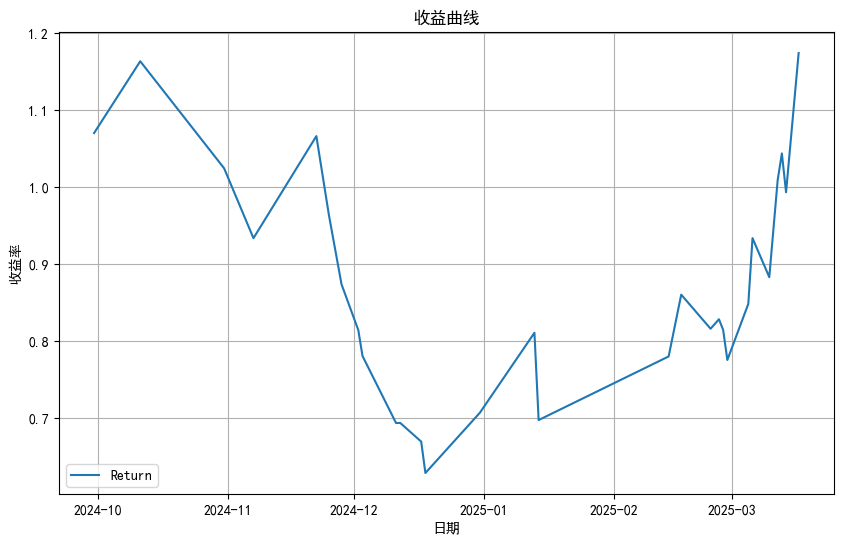

In [ ]:
plot(ddwndx, 'cumulative_returns')

In [ ]:
dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']

C:\Users\Administrator\AppData\Local\Temp\ipykernel_8940\2979096706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dwndx['r_pct'] = dwndx['real_open']/dwndx['open_price']


In [ ]:
pd.set_option('display.max_columns', None)
dwndx.sort_values(by='r_pct', ascending=False)

,id,strategy_name,sub_strategy_name,stock_code,stock_name,stock_rank,block_category,block_codes,industry_code,max_block_category_rank,max_block_code_rank,max_industry_code_rank,is_bottom,is_broken_plate,is_down_broken,is_fall,is_first_down_broken,is_first_up_broken,is_gestation_line,is_half,is_high,is_highest,is_long_shadow,is_low,is_medium,is_meso,is_plummet,is_pre_st,is_small_high_open,is_up_broken,is_weak,first_limit_up_days,jsjl,cjs,xcjw,jssb,open_pct_rate,open_price,close_price,pre_close_price,next_day_open_price,next_day_close_price,next_day_high_price_open_10mins,next_day_low_price_open_10mins,next_day_high_price,next_day_low_price,in_premarket,in_premarket_match,mod_code,mod_name,mod_short_line_score,mod_short_line_score_change,mod_short_line_rank,mod_trend_score,mod_trend_score_change,mod_trend_rank,created_at,first_tick_amount,return,real_return,close_return,close_real_return,close_1,low_1,close_2,low_2,close_3,low_3,close_4,low_4,close_5,low_5,close_6,low_6,close_7,low_7,close_8,low_8,close_9,low_9,close_10,low_10,real_open,r_return,cumulative_returns,r_pct
date_key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2025-01-14,1467,追涨,连断追涨,002571.XSHE,德力股份,1,"000012.BKDL,000018.BKDL,000035.BKDL,000010.BKD...","885910.DDBK,885413.DDBK,885431.DDBK,885835.DDB...",980373.ZHBK,1,2,18,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0.0,0.0,1024.13,1331.32,4.82,5.00,4.95,-1.0,4.69,4.46,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-1.39,108.27,18,-88.18,26.95,55,2025-02-15 21:43:30,44521505.0,-0.062000,-0.063000,-0.108000,-0.109000,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,5.18,-0.139996,0.697208,1.036000
2025-01-13,1448,追涨,连断追涨,002418.XSHE,康盛股份,1,,,,-1,-1,-1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0,0.0,437.85,156.61,1.76,3.46,3.74,-1.0,3.90,4.11,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-109.66,-1.62,66,-129.72,-2.97,76,2025-02-15 21:42:33,66616072.0,0.127168,0.126168,0.187861,0.186861,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,3.58,0.147045,0.810704,1.034682
2024-12-31,2520,追涨,连断追涨,002730.XSHE,电光科技,1,"000003.BKDL,000023.BKDL,000035.BKDL,000006.BKD...","885517.DDBK,885729.DDBK,885700.DDBK,885619.DDB...",980365.ZHBK,1,1,7,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0.0,0.0,719.19,28.39,0.15,12.94,13.66,-1.0,12.29,15.03,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-119.38,1.78,79,-119.33,0.32,77,2025-02-15 21:34:28,110633415.0,-0.050232,-0.051232,0.161515,0.160515,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,13.35,0.124843,0.706776,1.031685
2024-12-17,2315,追涨,连断追涨,000759.XSHE,中百集团,2,"000012.BKDL,000024.BKDL,000026.BKDL,000018.BKD...","885951.DDBK,886021.DDBK,885812.DDBK,885901.DDB...","980374.ZHBK,980345.ZHBK",1,2,8,0,1,1,0,0,0,0,0,1,1,0,0,1,0,0,0,1,0,0,0,0.0,0.0,1143.06,42.97,0.12,8.61,7.74,-1.0,6.97,8.51,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,-68.85,-31.34,70,-17.05,5.47,61,2025-02-15 21:24:34,236871621.0,-0.190476,-0.191476,-0.011614,-0.012614,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,8.81,-0.035052,0.669151,1.023229
2024-12-12,2191,追涨,连断追涨,002354.XSHE,天娱数科,1,"000012.BKDL,000003.BKDL,000038.BKDL,000026.BKD...","886017.DDBK,886062.DDBK,885456.DDBK,885603.DDB...","980753.ZHBK,980355.ZHBK",1,1,11,0,1,0,0,0,0,0,0,1,0,1,0,1,0,0,0,0,1,0,0,0.0,0.0,400.76,1057.62,7.51,8.30,7.73,-1.0,7.20,8.50,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,54.23,84.04,14,60.74,34.83,28,2025-02-15 21:21:11,286299187.0,-0.132530,-0.133530,0.024096,0.023096,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,8.49,0.000178,0.693459,1.022892
2025-02-24,3485,追涨,连断追涨,002290.XSHE,禾盛新材,1,,,,-1,-1,-1,0,1,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0.0,0.0,288.68,17.94,2.03,24.60,26.52,-1.0,24.00,23.87,-1.0,-1.0,-1.0,-1.0,0,0,9G0036,连断追涨,52.46,52.29,35,-15.42,19.98,52,2025-02-28 17:46:09,32474952.0,-0.024390,-0.025390,-0.029675,-0.030675,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,25.14,-0.051517,0.815946,1.021951
2025-02-27,3529,追涨,连断追涨,002369.XSHE,卓翼科技,1,"000012.BKDL,000003.BKDL,000014

<Axes: ylabel='Frequency'>

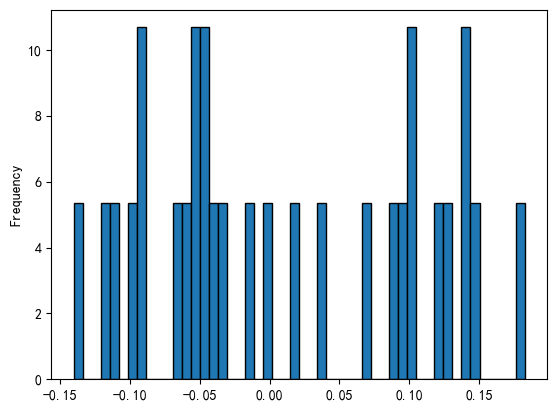

In [ ]:
ddwndx['r_return'].plot(kind='hist', bins=50, density=True, edgecolor='black')

In [ ]:
# 最大回撤: -14.59%
# 夏普比率: 0.29
# 总收益率: 234.78%
# 年化收益率: 722.40%
# 波动率: 5.95%
# 总盈亏: 235.83%
# 成功次数: 48
# 失败次数: 30
# 总天数: 78
# 总交易次数: 78
# 交易频率: 100.00%
# 胜率: 61.54%
# 平均盈利: 4.61%
# 平均亏损: -2.89%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 37.43%

In [ ]:
# return:
# 最大回撤: -14.59%
# 夏普比率: 0.28
# 总收益率: 192.71%
# 年化收益率: 690.29%
# 波动率: 6.32%
# 总盈亏: 194.90%
# 成功次数: 41
# 失败次数: 26
# 总天数: 67
# 总交易次数: 67
# 交易频率: 100.00%
# 胜率: 61.19%
# 平均盈利: 4.87%
# 平均亏损: -3.05%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.60
# 凯利公式最佳仓位: 36.91%

In [ ]:
# return:
# 最大回撤: -14.83%
# 夏普比率: 0.31
# 总收益率: 192.83%
# 年化收益率: 784.38%
# 波动率: 6.57%
# 总盈亏: 195.02%
# 成功次数: 36
# 失败次数: 23
# 总天数: 59
# 总交易次数: 59
# 交易频率: 100.00%
# 胜率: 61.02%
# 平均盈利: 5.23%
# 平均亏损: -2.96%
# 最大盈利: 23.18%
# 最大亏损: -9.73%
# 盈亏比: 1.76
# 凯利公式最佳仓位: 38.92%
